<a href="https://colab.research.google.com/github/monsebo/2DCNN-for-Tsunami-Intensity-Measure-prediction/blob/main/2DCNN_input_slip_output_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import glob
import tensorflow as tf


In [ ]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, '/content/drive/MyDrive/Data')

img_path =  os.path.join(data_dir,'slip_img.npz')
f = np.load(img_path)

slip_grd_all = f['slip_grd_all']
print(slip_grd_all.shape)

(1800, 61, 38)


In [ ]:
#load output run-up, inundation area
inund_path = os.path.join(data_dir, 'max_inundation.npz')
f = np.load(inund_path)

inund_px_all = f['inund_px_all']
print(inund_px_all.shape)
runup_all = f['runup_all']
print(runup_all.shape)

#load output hmax

#Viña del mar

viña_path = os.path.join(data_dir, 'vina_inland_gauge.npz')
f_viña = np.load(viña_path)
h_viña = f_viña['h']
#Valparaíso

valpo_path = os.path.join(data_dir, 'valpo_inland_gauge.npz')
f_valpo = np.load(valpo_path)
h_valpo = f_valpo['h']
#Cartagena

cartagena_path = os.path.join(data_dir, 'cartagena_inland_gauge.npz')
f_cartagena = np.load(cartagena_path)
h_cartagena = f_cartagena['h']
#San Antonio

sanantonio_path = os.path.join(data_dir, 'santonio_inland_gauge.npz')
f_santonio = np.load(sanantonio_path)
h_santonio = f_santonio['h']

#hmax para cada estación
hmax_viña = np.max(h_viña, axis = 1)
#print(hmax_viña.shape)
hmax_valpo = np.max(h_valpo, axis = 1)
#print(hmax_valpo.shape)
hmax_cartagena = np.max(h_cartagena, axis = 1)
#print(hmax_cartagena.shape)
hmax_santonio = np.max(h_santonio, axis = 1)
#print(hmax_santonio.shape)

#Vector 4x1 hV²max

h_max = np.stack((hmax_viña, hmax_valpo, hmax_cartagena, hmax_santonio), axis=-1)
print(h_max.shape)

(4, 1800)
(4, 1800)
(1800, 4)


In [ ]:
X = slip_grd_all
Y1 = runup_all.T  # 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y2 = inund_px_all.T/68771

In [ ]:
Y3 = h_max

In [ ]:
Y = np.hstack((Y1,Y2,Y3))
Y.shape

(1800, 12)

In [ ]:
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
#split data 80 and 20%
X_train, X_test = train_test_split(X, train_size=0.8, shuffle=True, random_state=1) # this split the slip data
Y_train, Y_test = train_test_split(Y, train_size=0.8, shuffle=True, random_state=1) # this split the run-up, inundation area and hmax data

In [ ]:
print(np.shape(X_train)) # should be (1440, 61, 38)
print(np.shape(Y_train)) # should be (1440, 12)

(1440, 61, 38)
(1440, 12)


In [ ]:
train_images = X_train
train_labels = Y_train
test_images = X_test
test_labels = Y_test

In [ ]:
max(train_images.max(), test_images.max())

52.264

In [ ]:
# Normalize the images. (between 0 and 1)
train_images = (train_images / 52.264)
test_images = (test_images / 52.264)

In [ ]:
# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (1440, 61, 38, 1)
print(test_images.shape)  # (180, 61, 38, 1)

(1440, 61, 38, 1)
(360, 61, 38, 1)


# 2D CNN model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, regularizers

L2 = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(61, 38, 1), kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='linear', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(12))


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam' , metrics=['mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 37, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 18, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 17, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 7, 32)         4128      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 3, 32)          0

In [ ]:
history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,
                    validation_data=(test_images, test_labels))

Epoch 1/200
45/45 [==============================] - 6s 13ms/step - loss: 22.1839 - mean_squared_error: 22.1484 - val_loss: 6.7751 - val_mean_squared_error: 6.7456
Epoch 2/200
45/45 [==============================] - 0s 5ms/step - loss: 6.2797 - mean_squared_error: 6.2534 - val_loss: 5.8806 - val_mean_squared_error: 5.8567
Epoch 3/200
45/45 [==============================] - 0s 5ms/step - loss: 5.9686 - mean_squared_error: 5.9462 - val_loss: 6.0750 - val_mean_squared_error: 6.0537
Epoch 4/200
45/45 [==============================] - 0s 5ms/step - loss: 5.6704 - mean_squared_error: 5.6499 - val_loss: 5.1082 - val_mean_squared_error: 5.0884
Epoch 5/200
45/45 [==============================] - 0s 5ms/step - loss: 4.8300 - mean_squared_error: 4.8105 - val_loss: 4.4663 - val_mean_squared_error: 4.4472
Epoch 6/200
45/45 [==============================] - 0s 5ms/step - loss: 4.1984 - mean_squared_error: 4.1795 - val_loss: 3.8647 - val_mean_squared_error: 3.8460
Epoch 7/200
45/45 [============

In [ ]:
predictions = model.predict(test_images)
train_predictions = model.predict(train_images)
#guardar datos en npy
#guardar variables en .npy
np.save('../content/drive/MyDrive/Data/predictions_slip_data1_12.npy',predictions)
np.save('../content/drive/MyDrive/Data/train_predictions_slip_data1_12.npy',train_predictions)

45/45 [==============================] - 0s 2ms/step


In [ ]:
h = history.history['mean_squared_error']
np.save('../content/drive/MyDrive/Data/history_slip_data1_12.npy',h)

In [ ]:
h_val = history.history['val_mean_squared_error']
np.save('../content/drive/MyDrive/Data/history_val_slip_data1_12.npy',h_val)

In [ ]:
#load variables
predictions = np.load('../content/drive/MyDrive/Data/predictions_slip_data1_12.npy')
train_predictions = np.load('../content/drive/MyDrive/Data/train_predictions_slip_data1_12.npy')
h = np.load('../content/drive/MyDrive/Data/history_slip_data1_12.npy')
h_val = np.load('../content/drive/MyDrive/Data/history_val_slip_data1_12.npy')

(1440, 12)
(360, 12)
MSE test: 0.7988156955829915
MSE train: 0.30170229997614667


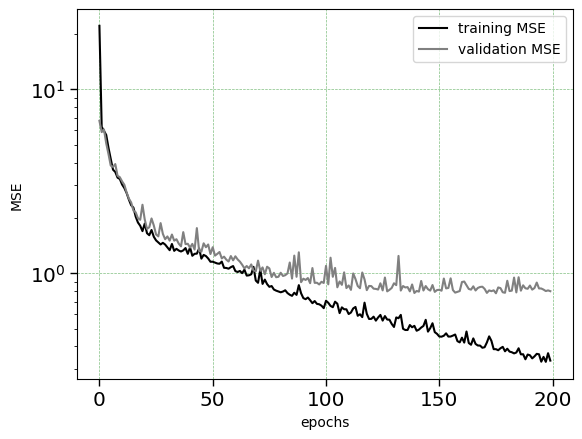

In [ ]:
plt.plot(h, label = 'training MSE', color="k")
plt.plot(h_val, label = 'validation MSE', color="gray")
plt.tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='g', grid_alpha=0.5, labelsize='x-large')
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('epochs')

y_star_train = train_predictions
y_star_test = predictions
print(np.shape(y_star_train))
print(np.shape(y_star_test))

MSE_test = np.average((y_star_test - test_labels)**2)
MSE_train = np.average((y_star_train - train_labels )**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)

In [ ]:
#R2 graphics for 45° line (1:1)
from sklearn.metrics import r2_score
y_true = test_labels[:,0]
y_pred= predictions[:,0]
r2_run1 = r2_score(y_true, y_pred)

y_true = test_labels[:,1]
y_pred= predictions[:,1]
r2_run2 = r2_score(y_true, y_pred)

y_true = test_labels[:,2]
y_pred= predictions[:,2]
r2_run3 = r2_score(y_true, y_pred)

y_true = test_labels[:,3]
y_pred= predictions[:,3]
r2_run4 = r2_score(y_true, y_pred)

y_true = test_labels[:,4]
y_pred= predictions[:,4]
r2_ia1 = r2_score(y_true, y_pred)

y_true = test_labels[:,5]
y_pred= predictions[:,5]
r2_ia2 = r2_score(y_true, y_pred)

y_true = test_labels[:,6]
y_pred= predictions[:,6]
r2_ia3 = r2_score(y_true, y_pred)

y_true = test_labels[:,7]
y_pred= predictions[:,7]
r2_ia4 = r2_score(y_true, y_pred)

y_true = test_labels[:,8]
y_pred= predictions[:,8]
r2_hmax1 = r2_score(y_true, y_pred)

y_true = test_labels[:,9]
y_pred= predictions[:,9]
r2_hmax2 = r2_score(y_true, y_pred)

y_true = test_labels[:,10]
y_pred= predictions[:,10]
r2_hmax3 = r2_score(y_true, y_pred)

y_true = test_labels[:,11]
y_pred= predictions[:,11]
r2_hmax4 = r2_score(y_true, y_pred)

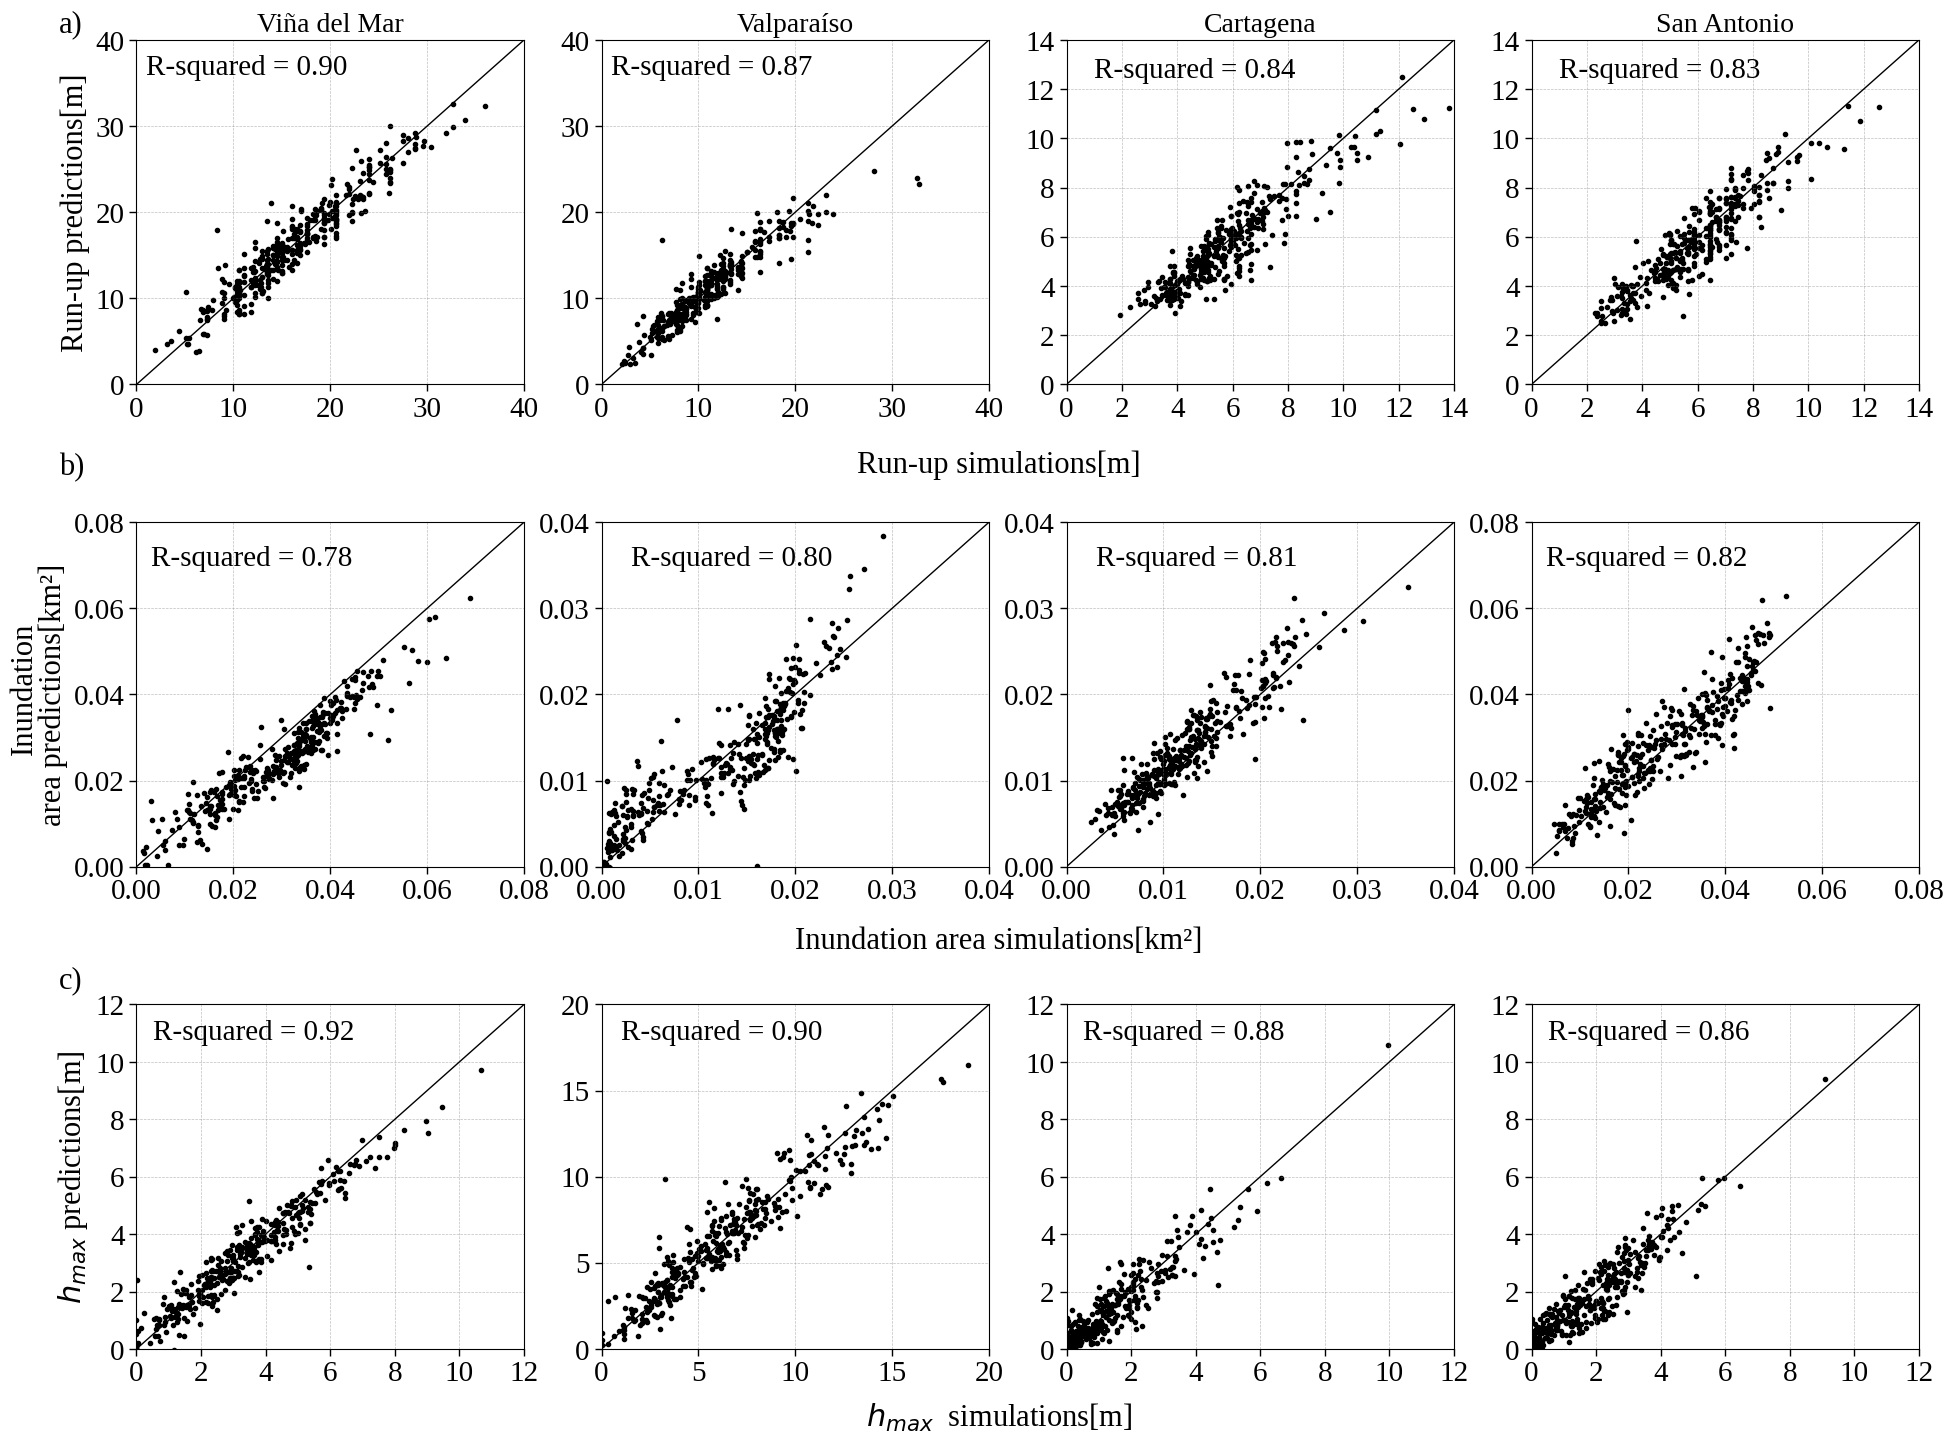

In [ ]:
# Graphics
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

# Font Liberation Serif
font_path = fm.findSystemFonts(fontpaths=None, fontext='ttf')
liberation_serif_fonts = [font for font in font_path if 'liberationserif' in font.lower()]

liberation_serif_font = liberation_serif_fonts[0] if liberation_serif_fonts else None

if liberation_serif_font:
    plt.rcParams['font.family'] = "Liberation Serif"

f, ax = plt.subplots(3, 4, figsize=(23, 17), gridspec_kw={'hspace': 0.4})
# run-up
ax[0,0].scatter(test_labels[:,0], predictions[:,0], color = 'k', marker = '.')
ax[0,0].set_title("Viña del Mar",fontsize = 20)
ax[0,0].set_ylabel('Run-up predictions[m]',fontsize = 22 )
ax[0,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,0].tick_params(axis="x", labelsize=21)
ax[0,0].tick_params(axis="y", labelsize=21)
ax[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,0].set_xlim([0, 40])
ax[0,0].set_ylim([0, 40])
ax[0,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run1)
ax[0,0].text(1, 36, f'R-squared = {r2_run1:.2f}', fontsize=21, color='k')
ax[0,0].text(-8, 41, 'a)', fontsize = 22)
ax[0,0].text(-8, -10.5, 'b)', fontsize = 22)
ax[0,0].text(-8, -70, 'c)', fontsize = 22)

ax[0,1].scatter(test_labels[:,1], predictions[:,1], color = 'k', marker = '.')
ax[0,1].set_title("Valparaíso",fontsize = 20)
ax[0,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,1].tick_params(axis="x", labelsize=21)
ax[0,1].tick_params(axis="y", labelsize=21)
ax[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,1].set_xlim([0, 40])
ax[0,1].set_ylim([0, 40])
ax[0,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run2)
ax[0,1].text(1, 36, f'R-squared = {r2_run2:.2f}', fontsize=21, color='k')

ax[0,2].scatter(test_labels[:,2], predictions[:,2], color = 'k', marker = '.')
ax[0,2].set_title("Cartagena", fontsize = 20)
ax[0,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,2].tick_params(axis="x", labelsize=21)
ax[0,2].tick_params(axis="y", labelsize=21)
ax[0,2].set_xlim([0, 14])
ax[0,2].set_ylim([0, 14])
ax[0,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run3)
ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].text(1, 12.5, f'R-squared = {r2_run3:.2f}', fontsize=21, color='k')


ax[0,3].scatter(test_labels[:,3], predictions[:,3], color = 'k', marker = '.')
ax[0,3].set_title("San Antonio", fontsize = 20)
ax[0,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,3].tick_params(axis="x", labelsize=21)
ax[0,3].tick_params(axis="y", labelsize=21)
ax[0,3].set_xlim([0, 14])
ax[0,3].set_ylim([0, 14])
ax[0,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_run4)
ax[0,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].text(1, 12.5, f'R-squared = {r2_run4:.2f}', fontsize=21, color='k')

f.text(0.5, 0.63, 'Run-up simulations[m]', ha='center', va='center', fontsize=22)

#inundation area
ax[1,0].scatter(test_labels[:,4]*68771*1e-6, predictions[:,4]*68771*1e-6, color = 'k', marker = '.')
f.text(0.07, 0.46, 'Inundation', ha='left', va='bottom', fontsize=22, rotation=90)
ax[1,0].set_ylabel('area predictions[km²]',fontsize = 22 )
ax[1,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,0].tick_params(axis="x", labelsize=21)
ax[1,0].tick_params(axis="y", labelsize=21)
ax[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,0].set_xlim([0, .08])
ax[1,0].set_ylim([0, .08])
ax[1,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia1)
ax[1,0].text(0.003, 0.07, f'R-squared = {r2_ia1:.2f}', fontsize=21, color='k')

ax[1,1].scatter(test_labels[:,5]*68771*1e-6, predictions[:,5]*68771*1e-6, color = 'k', marker = '.')
ax[1,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,1].tick_params(axis="x", labelsize=21)
ax[1,1].tick_params(axis="y", labelsize=21)
ax[1,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,1].set_xlim([0, .04])
ax[1,1].set_ylim([0, .04])
ax[1,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia2)
ax[1,1].text(0.003, 0.035, f'R-squared = {r2_ia2:.2f}', fontsize=21, color='k')

ax[1,2].scatter(test_labels[:,6]*68771*1e-6, predictions[:,6]*68771*1e-6, color = 'k', marker = '.')
ax[1,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,2].tick_params(axis="x", labelsize=21)
ax[1,2].tick_params(axis="y", labelsize=21)
ax[1,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,2].set_xlim([0, .04])
ax[1,2].set_ylim([0, .04])
ax[1,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia3)
ax[1,2].text(0.003, 0.035, f'R-squared = {r2_ia3:.2f}', fontsize=21, color='k')


ax[1,3].scatter(test_labels[:,7]*68771*1e-6, predictions[:,7]*68771*1e-6, color = 'k', marker = '.')
ax[1,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,3].tick_params(axis="x", labelsize=21)
ax[1,3].tick_params(axis="y", labelsize=21)
ax[1,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,3].set_xlim([0, .08])
ax[1,3].set_ylim([0, .08])
ax[1,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_ia4)
ax[1,3].text(0.003, 0.07, f'R-squared = {r2_ia4:.2f}', fontsize=21, color='k')

#f.supxlabel('NSWE simulations[km²]',fontsize = 26)
f.text(0.5, 0.35, 'Inundation area simulations[km²]', ha='center', va='center', fontsize=22)

#hmax
ax[2,0].scatter(test_labels[:,8], predictions[:,8], color = 'k', marker = '.')
ax[2,0].set_ylabel('$h_{max}$ predictions[m]',fontsize = 22 )
ax[2,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,0].tick_params(axis="x", labelsize=21)
ax[2,0].tick_params(axis="y", labelsize=21)
ax[2,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,0].set_xlim([0, 12])
ax[2,0].set_ylim([0, 12])
ax[2,0].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax1)
ax[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,0].text(0.5, 10.8, f'R-squared = {r2_hmax1:.2f}', fontsize=21, color='k')

ax[2,1].scatter(test_labels[:,9], predictions[:,9], color = 'k', marker = '.')
ax[2,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,1].tick_params(axis="x", labelsize=21)
ax[2,1].tick_params(axis="y", labelsize=21)
ax[2,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,1].set_xlim([0, 20])
ax[2,1].set_ylim([0, 20])
ax[2,1].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax2)
ax[2,1].text(1, 18, f'R-squared = {r2_hmax2:.2f}', fontsize=21, color='k')


ax[2,2].scatter(test_labels[:,10], predictions[:,10], color = 'k', marker = '.')
ax[2,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,2].tick_params(axis="x", labelsize=21)
ax[2,2].tick_params(axis="y", labelsize=21)
ax[2,2].set_xlim([0, 12])
ax[2,2].set_ylim([0, 12])
ax[2,2].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax3)
ax[2,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,2].text(0.5, 10.8, f'R-squared = {r2_hmax3:.2f}', fontsize=21, color='k')


ax[2,3].scatter(test_labels[:,11], predictions[:,11], color = 'k', marker = '.')
ax[2,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[2,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[2,3].tick_params(axis="x", labelsize=21)
ax[2,3].tick_params(axis="y", labelsize=21)
ax[2,3].set_xlim([0, 12])
ax[2,3].set_ylim([0, 12])
ax[2,3].axline([0,0], [1,1], color="k", linewidth=1, label='R-squared = %0.2f' % r2_hmax4)
ax[2,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,3].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2,3].text(0.5, 10.8, f'R-squared = {r2_hmax4:.2f}', fontsize=21, color='k')

f.text(0.5, 0.07, '$h_{max}$  simulations[m]', ha='center', va='center', fontsize=22)

plt.savefig('/content/drive/MyDrive/Data/Figure4.pdf', bbox_inches='tight', dpi=800)


# CNN model
## Prior and training model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Lambda, add,  Activation, concatenate, Input, Embedding
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.losses import MeanSquaredError
tfd = tfp.distributions
tfpl = tfp.layers

## Standard deviation of data

,0
count,1800.000000
mean,16.198757
std,5.999486
min,1.958326
25%,12.035325
50%,15.484854
75%,20.173637
max,40.159824


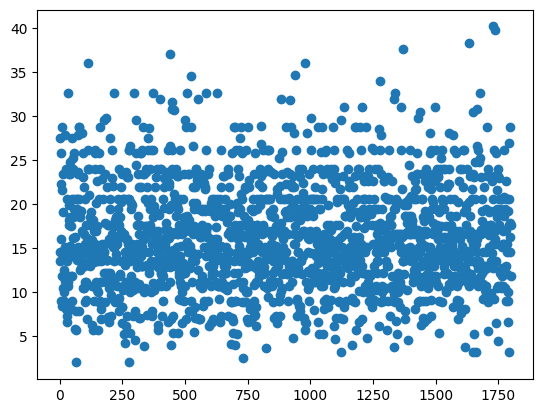

In [ ]:
df_describe = pd.DataFrame(runup_all[0])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

,0
count,1800.000000
mean,28197.698889
std,12619.029488
min,312.000000
25%,19053.750000
50%,30293.000000
75%,37108.500000
max,68771.000000


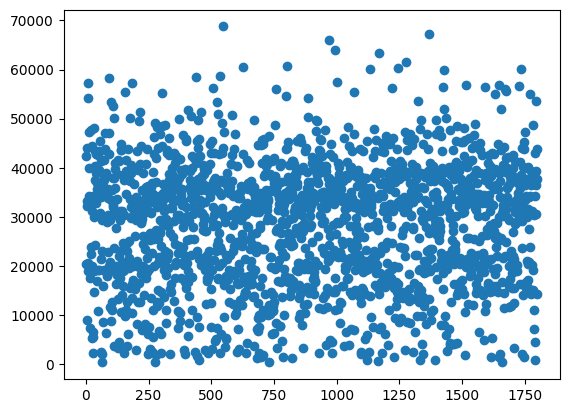

In [ ]:
df_describe = pd.DataFrame(inund_px_all[0])
x = np.linspace(1,1800,1800)
np.shape(x)
plt.scatter(x, df_describe)
df_describe.describe()

In [ ]:
# prior network output #

# shared input of the network
net_input = Input(shape=(61, 38, 1),name='input')

# let us build the prior network
L2 = 0.0001
prior_net = Sequential([
  Conv2D(16, (2, 2),  activation='relu', input_shape=(61, 38, 1),kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
], name='prior_net')(net_input)

prior_output = Dense(12,'linear',kernel_initializer='glorot_normal',
                     trainable=False, name='prior_out')(prior_net)


# compiling a model for this network
prior_model = Model(inputs=net_input, outputs=prior_output)


In [ ]:
# adding trainable network

# trainable network body

trainable_net = Sequential([
  Conv2D(16, (2, 2),  activation='relu', input_shape=(61, 38, 1),kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(32, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu',  kernel_regularizer=regularizers.l2(L2)),
], name='trainable_net')(net_input)

# trainable network output

trainable_output = Dense(12,'linear', name='trainable_out')(trainable_net)

# using a lambda layer so we can control the weight (beta) of the prior network

prior_scale = Lambda(lambda x: x * 30, name='prior_scale')(prior_output) #beta = sd*5=12091*5

# lastly, we use a add layer to add both networks together and get Q

add_output = add([trainable_output, prior_scale], name='add')

# defining the model
model = Model(inputs=net_input, outputs=add_output)

trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 61, 38, 1)]          0         []                            
                                                                                                  
 prior_net (Sequential)      (None, 64)                   76208     ['input[0][0]']               
                                                                                                  
 trainable_net (Sequential)  (None, 64)                   76208     ['input[0][0]']               
                                                                                                  
 prior_out (Dense)           (None, 12)                   780       ['prior_net[0][0]']           
                                                                                            

### Running 30 times the NN

In [ ]:
nsims=30
prior_pred = prior_model.predict(test_images)

predict= np.zeros([360,12,nsims])
train_predict = np.zeros([360,12,nsims])


for i in range(nsims):
  model = Model(inputs=net_input, outputs=add_output)
  trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,validation_data=(test_images, test_labels))

  predict[:,:,i] = model.predict(test_images)
  train_predict[:,:,i] = trainable_model(test_images)



Streaming output truncated to the last 5000 lines.
Epoch 108/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0844 - mean_squared_error: 0.0187 - val_loss: 1.0881 - val_mean_squared_error: 1.0224
Epoch 109/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0824 - mean_squared_error: 0.0167 - val_loss: 1.0734 - val_mean_squared_error: 1.0077
Epoch 110/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0830 - mean_squared_error: 0.0173 - val_loss: 1.0774 - val_mean_squared_error: 1.0117
Epoch 111/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0872 - mean_squared_error: 0.0215 - val_loss: 1.0768 - val_mean_squared_error: 1.0111
Epoch 112/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0920 - mean_squared_error: 0.0263 - val_loss: 1.0929 - val_mean_squared_error: 1.0272
Epoch 113/200
45/45 [==============================] - 0s 7ms/step - loss: 0.0914 - mean_squared_error: 0.0257 - val_loss: 1.0933 - va

In [ ]:
#Save variables en .npy
np.save('../content/drive/MyDrive/Data/predict_slip_data1_bayesian_12.npy',predict)
np.save('../content/drive/MyDrive/Data/train_slip_data1_bayesian_predict_12.npy',train_predict)
np.save('../content/drive/MyDrive/Data/prior_slip_data1_bayesian_predict_12.npy',prior_pred)

In [ ]:
#Load variables
predict=np.load('../content/drive/MyDrive/Data/predict_slip_data1_bayesian_12.npy')
train_predict=np.load('../content/drive/MyDrive/Data/train_slip_data1_bayesian_predict_12.npy')
prior_pred=np.load('../content/drive/MyDrive/Data/prior_slip_data1_bayesian_predict_12.npy')
print(predict.shape)
print(train_predict.shape)
print(prior_pred.shape)

(360, 12, 30)
(360, 12, 30)
(360, 12)


In [ ]:
# SD and Mean
means=np.mean(predict[:,0,:], axis=1)
stddev=np.std(predict[:,0,:],axis=1,ddof=1)
print(means.shape)
print(stddev.shape)
print(np.max(stddev))

(360,)
(360,)
2.086318049237832
